# Prompting-Based Experiments

In [291]:
import re
import os
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import numpy as np
import pandas as pd

In [292]:
SHOTS = 3

In [293]:
sns.set_theme()
sns.set_style("whitegrid")
plt.style.use("alan.mplstyle")
ROOT = Path("../src/experiments/data/baselines-cot")

In [447]:
tasks = ["sports"]
strat = ["fs", "zero", "cot", "fsm"]
shots = {
    "fs": 3, 
    "fsm": 5,
    "zero": 1,
    "cot": 3,
}
MNAME = "gemma-9b"

In [448]:
# get all results
results = dict()
for task in tasks:
    results[task] = dict()
    for st in strat:
        results[task][st] = pickle.load(open(ROOT / f"{MNAME}-{task}-{st}-benchmark.pkl", "rb"))

In [449]:
IDX = 5
print(results["movie"]["cot"]["output"][IDX])
print("--------------")
print()


KeyError: 'movie'

## Parsers

In [450]:
def parse(response):
    ptrn = re.compile("A: .*")
    return re.findall(ptrn, response)

def cot_parse(response):
    ptrn = re.compile("So the answer is .*")
    return re.findall(ptrn, response)

def correct_cot(response, shots, target):
    parsed = cot_parse(response)
    if parsed is None or len(parsed) <= shots:
        return 0
    else:
        return target in parsed[shots] 

def correct(response, shots, target):
    parsed = parser(response)
    if parsed is None or len(parsed) <= shots:
        return 0
    else:
        return target.strip().lower() in parsed[shots].strip().lower()

In [451]:
scores = dict()
for task in tasks:
    scores[task] = dict()
    for st in strat: 
        if st == "cot":
            crt = correct_cot
        else:
            crt = correct
        scores[task][st] = sum([
            crt(v, shots[st], t)
            for v,t in zip(results[task][st]["output"], results[task][st]["target"])
        ]) / len(results[task][st]["output"])

In [452]:
scores

{'sports': {'fs': 0.092, 'zero': 0.12, 'cot': 0.788, 'fsm': 0.08}}

In [416]:
import pandas as pd

df = pd.DataFrame()

In [418]:
df

,sports,date
fs,0.432,0.178862
zero,0.408,0.130081
cot,0.768,0.346883
fsm,0.408,0.246612


<Axes: >

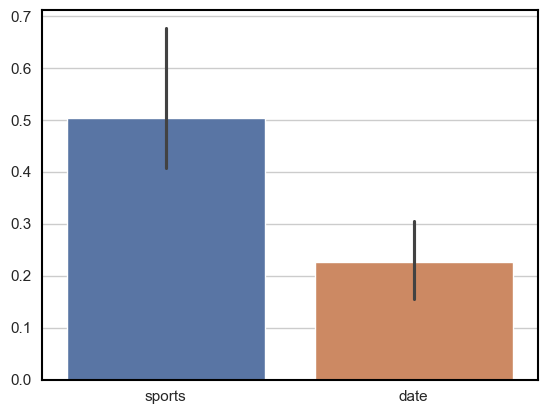

In [419]:
sns.barplot(df)

# Garbage

In [208]:
def cot_parse(response):
    ptrn = re.compile(r"So the answer is.*([\}\)\]\{\[\(])")
    return re.findall(ptrn, response)

def zero_parse(in_str, target_str, response):
    ptrn = re.compile(re.escape(f"Input: {in_str}\nA: {in_str+target_str}"))
    return re.search(ptrn, response)

def parse(response):
    ptrn = re.compile(r"A: [\}\)\]]\n")
    return re.findall(ptrn, response)

def acc(response, target, parse_func, verbose=False):
    answers = parse_func(response)
    if len(answers) <= 3:
        return False
    if verbose and answers[SHOTS][-2:].strip() != target:
        print(answers, target)
    return answers[SHOTS][-2:].strip() == target

In [209]:
from functools import partial

In [210]:
correct_cot = 0
correct = 0
correct_zero = 0
for i in range(len(meta_dyck["predictions"])):
    pred_cot, target_cot = meta_dyck_cot["predictions"][i], meta_dyck_cot["targets"][i]
    x = acc(pred_cot, target_cot, cot_parse)
    if not x:
        print(replace_special(pred_cot))
        print("------------")
    correct_cot += x 
    pred, target = meta_dyck["predictions"][i], meta_dyck["targets"][i]
    ac_few = acc(pred, target, parse, verbose=False)

    correct += ac_few
    
    pred_zero, target_zero = zero["predictions"][i], zero["targets"][i]
    in_str = zero["inputs"][i]
    zparse = zero_parse(in_str, target_zero, pred_zero)
    correct_zero += 0 if zparse is None else 1
correct, correct_cot, correct_zero = correct / 1000, (correct_cot + 51) / 1000, correct_zero / 1000

<|eot_id|><|eot_id|><|begin_of_text|>Correctly close a Dyck-n word.

Q: Complete the rest of the sequence, making sure that the parentheses are closed properly. Input: [(){}
A: Let's think step by step.
We should process each input one by one and keep track of the stack configuration.
0: empty stack
1: [ ; stack: [
2: ( ; stack: [(
3: ) ; stack: [
4: { ; stack: [{
5: } ; stack: [
So the answer is ]

Q: Complete the rest of the sequence, making sure that the parentheses are closed properly. Input: {[]()
A: Let's think step by step.
We should process each input one by one and keep track of the stack configuration.
0: empty stack
1: { ; stack: {
2: [ ; stack: {[
3: ] ; stack: {
4: ( ; stack: {(
5: ) ; stack: {
So the answer is }

Q: Complete the rest of the sequence, making sure that the parentheses are closed properly. Input: {([])
A: Let's think step by step.
We should process each input one by one and keep track of the stack configuration.
0: empty stack
1: { ; stack: {
2: ( ; stack: {

Text(0.5, 0, 'Prompting Strategy')

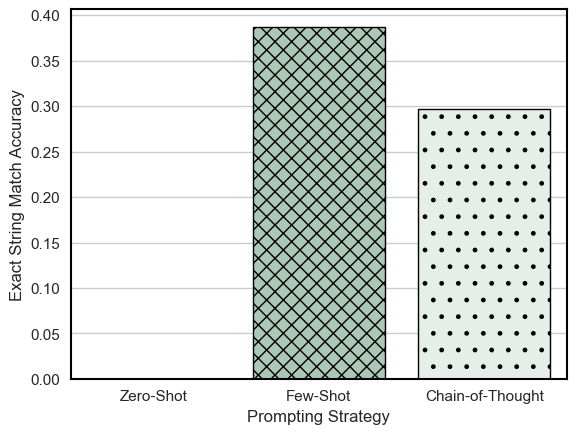

In [212]:
data = {
    "Prompting Strategy": ["Zero-Shot", "Few-Shot", "Chain-of-Thought"],
    "Exact String Match Accuracy": [correct_zero, correct, correct_cot],
}

# Generate color palette from cmap
cmap = sns.light_palette("seagreen", as_cmap=True, reverse=True)
palette = [cmap(i / (len(data["Prompting Strategy"])) + 0.3) for i in range(len(data["Prompting Strategy"]))]

ax = sns.barplot(data=data, x="Prompting Strategy", y="Exact String Match Accuracy", edgecolor="black", hue="Prompting Strategy", palette=palette)

hatching = ["\\\\", "xx", "."]

for i, bar in enumerate(ax.patches):
    bar.set_hatch(hatching[i])

ax.set_ylabel("Exact String Match Accuracy")
ax.set_xlabel("Prompting Strategy")

## Processing CoT and Few-Shot Responses

In [146]:
s_toks = ["<|endoftext|>", "<|im_end|>"]

def replace_special(resp):
    escaped_special = [re.escape(v) for v in s_toks]
    ptrn = f"({'|'.join(escaped_special)})"
    ptrn = re.compile(ptrn)
    return re.sub(ptrn, "", resp)
    

In [147]:
# check how many have "So the answer is"
sa = lambda x: len(re.findall("So the answer", x)) > 3

In [163]:
meta_dyck["predictions"] = [replace_special(v) for v in meta_dyck["predictions"]]

In [164]:
zero["predictions"] = [replace_special(v) for v in zero["predictions"]]

In [165]:
meta_dyck_cot["predictions"] = [replace_special(v) for v in meta_dyck_cot["predictions"]]

In [168]:
json.dump(meta_dyck, open(ROOT / "processed_dyck_few.json", "w"))
json.dump(meta_dyck_cot, open(ROOT / "processed_dyck_cot.json", "w"))
json.dump(zero, open(ROOT / "processed_zero.json", "w"))

In [170]:
print(meta_dyck_cot["predictions"][2])

Correctly close a Dyck-n word.

Q: Complete the rest of the sequence, making sure that the parentheses are closed properly. Input: [(){}
A: Let's think step by step.
We should process each input one by one and keep track of the stack configuration.
0: empty stack
1: [ ; stack: [
2: ( ; stack: [(
3: ) ; stack: [
4: { ; stack: [{
5: } ; stack: [
So the answer is ]

Q: Complete the rest of the sequence, making sure that the parentheses are closed properly. Input: {[]()
A: Let's think step by step.
We should process each input one by one and keep track of the stack configuration.
0: empty stack
1: { ; stack: {
2: [ ; stack: {[
3: ] ; stack: {
4: ( ; stack: {(
5: ) ; stack: {
So the answer is }

Q: Complete the rest of the sequence, making sure that the parentheses are closed properly. Input: {([])
A: Let's think step by step.
We should process each input one by one and keep track of the stack configuration.
0: empty stack
1: { ; stack: {
2: ( ; stack: {(
3: [ ; stack: {([
4: ] ; stack: {(


In [175]:
def find_answer_start(text, K):
    matches = [m.start() for m in re.finditer(r'\bA: ', text)]
    return matches[K] if len(matches) > K else -1

In [177]:
idx = find_answer_start(meta_dyck_cot["predictions"][2], 3)

In [178]:
print(meta_dyck_cot["predictions"][2][idx:])

A: Let's think step by step.
We should process each input one by one and keep track of the stack configuration.
0: empty stack
1: ( ; stack: (
2: { ; stack: ({ 
3: ( ; stack: ({(
4: ) ; stack: ({
5: } ; stack: (
6: [ ; stack: ([
7: ] ; stack: (
So the answer is ).

The completed Dyck-n word is: ({}()).dataGridView1

